# `III. Multipole Expansion` 
This .pynb file reads `./inter_results/field_result.pkl` generated by `./II_Field_Simulation.ipynb`, and analyzes the field distribution result. This analysis can be specific according to your own need. Here, as an example, we focus on multipole expansion coefficient. 

## (1) import electric field and set parameters for it.

In [1]:
import sys
sys.path.append('../../')
import pickle
# add multipoles package path
import pandas as pd
from utils.multipoles import MultipoleControl
from utils.plottingfuncns import *

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
import os
import matplotlib.cm as cm
from collections import OrderedDict
module_path = os.path.abspath('')

## Import Simulated Data

In [2]:
###### loading in pickle file ###############################
# import data, and define parameters
module_path = os.path.abspath('')

radius= 100e-3
area = 5e-6

radius= 100-3
area = 5e-6
path = module_path+'/inter_results/inter_results_mit/mit_LL_'+str(radius)+'_'+str(area)+'_simulation.pkl'
path = module_path+'/inter_results/inter_results_mit/charge_mit_charge_0.1_5e-06_simulation.pkl'
path = module_path+'/inter_results/roughness/simple_roughness_1.0_2e-06_simulation.pkl'

f = open(path, 'rb')
trap = pickle.load(f)
#############################################################

In [3]:

###### setting up multipole expansion @ trap location #######
#xl, yl, zl define the origin at which we will do the multipole expansion
#i.e. they define where you want to trap

#strs are the string names of your DC electrodes (copy from loading pickle,
#I wrote it a second time so that the code runs in case you comment out that code)
# strs = "DC1 DC2 DC3 DC4 DC5 DC6 DC7 DC8 DC9 DC10 DC11 DC12 DC13 DC14 DC15 DC16 DC17 DC18 DC19 DC20".split()
# strs = "DC21 ".split()
# strs = "DC5".split()
# strs = list(trap['electrodes'].keys())
# zl = 270*1e-3
# xl = -3.75*1e-3
# yl = 72.65*1e-3

xl = 0
yl = 100e-3
zl=0


position = [xl, yl, zl]

#ROI = 'range of interest', I believe
#It defines the volume region over which multipole expansion will be performed.
#nROI is the number of points that make up the dimensions of the volume of the ROI
#I believe it ends up being the indices of the 3-d array that you index so it is dimensionless
nROI = 3
roi = [nROI, nROI, nROI]
order = 2

#controlled electrodes- this will define which electrodes will be used to control your trap
controlled_electrodes = []

## (2) set parameters for multipole expansion
notes:
* new from shuqi's code- 'excl' defines a dictionary of excluded electrodes the dictionary index (left of colon)  is the electrode you want to exclude its value (right of colon) defines what you want to set it to if you set it to "gnd" it will always set the voltage of that DC to 0 if you set it to "DCx" it will always set the voltage of that DC to be the same as DCx this is in case you have trap shorts, if you don't need it just don't include the indices

In [4]:
# excl = {
#     "DC9":"gnd",
#     "DC11":"gnd",
#     "RF":"gnd",
#     "DC0":"gnd"
#     "DC2":"DC3"

# }
excl = {}
print(strs)
#build the controlled electrodes list, given the constraints of the 'excl' list
for electrode in strs:
    if electrode in excl and excl[electrode] != "gnd":
        trap['electrodes'][excl[electrode]]["potential"] = trap['electrodes'][excl[electrode]]["potential"] + \
                                                           trap['electrodes'][electrode]["potential"]
    elif electrode not in excl:
        controlled_electrodes.append(electrode)

#which multipoles you want to include in multipole calculations
used_order1multipoles = ['Ex', 'Ey', 'Ez']
used_order2multipoles = ['U1', 'U2', 'U3','U4','U5']
used_multipoles = used_order1multipoles + used_order2multipoles
print(np.shape(trap['electrodes'][electrode]["potential"]))

# create MultipoleControl object
s = MultipoleControl(trap, position, roi, controlled_electrodes, used_multipoles, order)
# s.electrode_positions = OrderedDict([('DC1', [0, 1]), ('DC2', [0, 2]), ('DC3', [0, 3]), ('DC4', [0, 4]), 
#              ('DC5', [0, 5]), ('DC6', [0, 6]), ('DC7', [0, 7]), ('DC8', [0, 8]), 
#              ('DC9', [0, 9]), ('DC10', [1, 5]), ('DC11', [3, 1]), ('DC12', [3, 2]), 
#              ('DC13', [3, 3]), ('DC14', [3, 4]), ('DC15', [3, 5]),('DC16', [3, 6]),
#              ('DC17', [3, 7]),('DC18', [3, 8]),('DC19', [3, 9]),('DC20', [2, 5])])
print(controlled_electrodes)

#     return s
# s,used_multipoles = generate_s(excl)
###############################################################

NameError: name 'strs' is not defined

(100,)


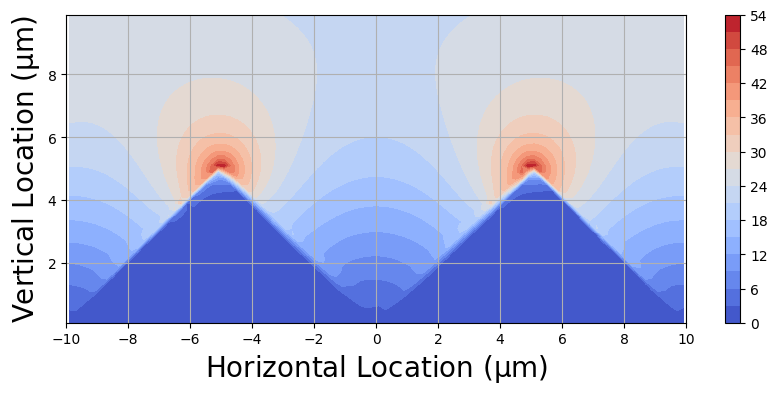

In [ ]:
# fig = plt.figure()
# ax = plt.axes(projection='3d')
import plotly.graph_objects as go


q = 1.6*1e-19
l = 1e-3
m = 40*1.66054e-27
Omega = 2*np.pi*35*1e6
# voltage = 80/5
d = trap['electrodes']['RF']['potential'][:,2,:]**0.5
print(np.shape(trap['X']))
# x,y,z= d.nonzero()
t = np.arange(100)
# ax.scatter(x, y, z, c=np.swapaxes(d,1,2), alpha=0.01,vmin=0,vmax=5,cmap = "viridis")
# ax.set_xlabel('x')
# ax.set_ylabel('y')
# ax.set_zlabel('z')
# ax.set_title('3D contour')
# plt.show()
minp = np.min(d)
maxp= np.max(d)
plt.figure(figsize=(10,4))
CS = plt.contourf(trap['X']*1e3,trap['Z']*1e3,np.transpose(d),levels=20,cmap=plt.cm.coolwarm,)
# plt.clabel(CS, inline=1, fontsize=25)
plt.xlabel(r"Horizontal Location ($\mathrm{\mu}$m)",fontsize=20)
plt.colorbar()
plt.grid()
plt.xticks(np.arange(-10,12,2))
plt.ylabel(r"Vertical Location ($\mathrm{\mu}$m)",fontsize=20)
plt.show()


# from mpl_toolkits import mplot3d
# # fig = plt.figure()
# # ax = plt.axes(projection='3d')
# # x,y= np.meshgrid(trap['X'],trap['Y'])
# # ax.contour3D(x,y,d,levels=30)
# layout = go.Layout(title="|E|^2 for 1Vp-p RF rail", 
#                    xaxis = dict(title = 'x-location'),
#                    yaxis = dict(title = 'y-location'))
# fig = go.Figure(data=[go.Surface(z=d)],layout=layout)
# fig.update_layout( autosize=False,
#                   width=500, height=500,
#                   margin=dict(l=65, r=50, b=65, t=90))

# fig.show()

# ################# writing to cfile ############################
# #write solution text file (cfile, sqip uses .txt format tho)
# #this will be generated in the 'Electrodes' directory
# # s.write_txt('mit_LL_ele5', strs, excl)
# ###############################################################


# ########## various plots of the expansion fields ##############
# ### TO DO: comments, checking multipoles generated, add RF electrode
# # code to the bottom

# print('Multipole names:', s.multipole_names)
# print('Normalization factors:', s.normalization_factors)
# print(controlled_electrodes)

## (3) compute desired voltage configuration and plot result
height list is a list of places to expand the field generated by each electrode

In [ ]:
height_list = trap['Z'][np.arange(nROI,len(trap['Z'])-nROI,1)]
numMUltipoles = len(s.multipole_print_names)
ne = len(s.electrode_names)
multipoles_vs_height = np.zeros((len(height_list), numMUltipoles, ne))
print('height_list:',height_list)
for i, height in enumerate(height_list):
    position1 = [xl, yl,height]
    s.update_origin_roi(position1, roi)
    multipoles_vs_height[i] = np.asarray(s.multipole_expansion.loc[s.multipole_names])

height_list: [-0.013 -0.011 -0.009 -0.007 -0.005 -0.003 -0.001  0.001  0.003  0.005
  0.007  0.009  0.011  0.013]


## Plotting Multipole Decomposition for electrodes
Plots the multipole decomposition of the field generated from putting 1V on each electrode vs height 

Height here currently refers to the axial location along the trap

['DC21']


/Users/Ben/opt/anaconda3/envs/bem_c/lib/python3.9/site-packages/utils/plottingfuncns.py:98: UserWarning:

FixedFormatter should only be used together with FixedLocator



<Figure size 640x480 with 0 Axes>

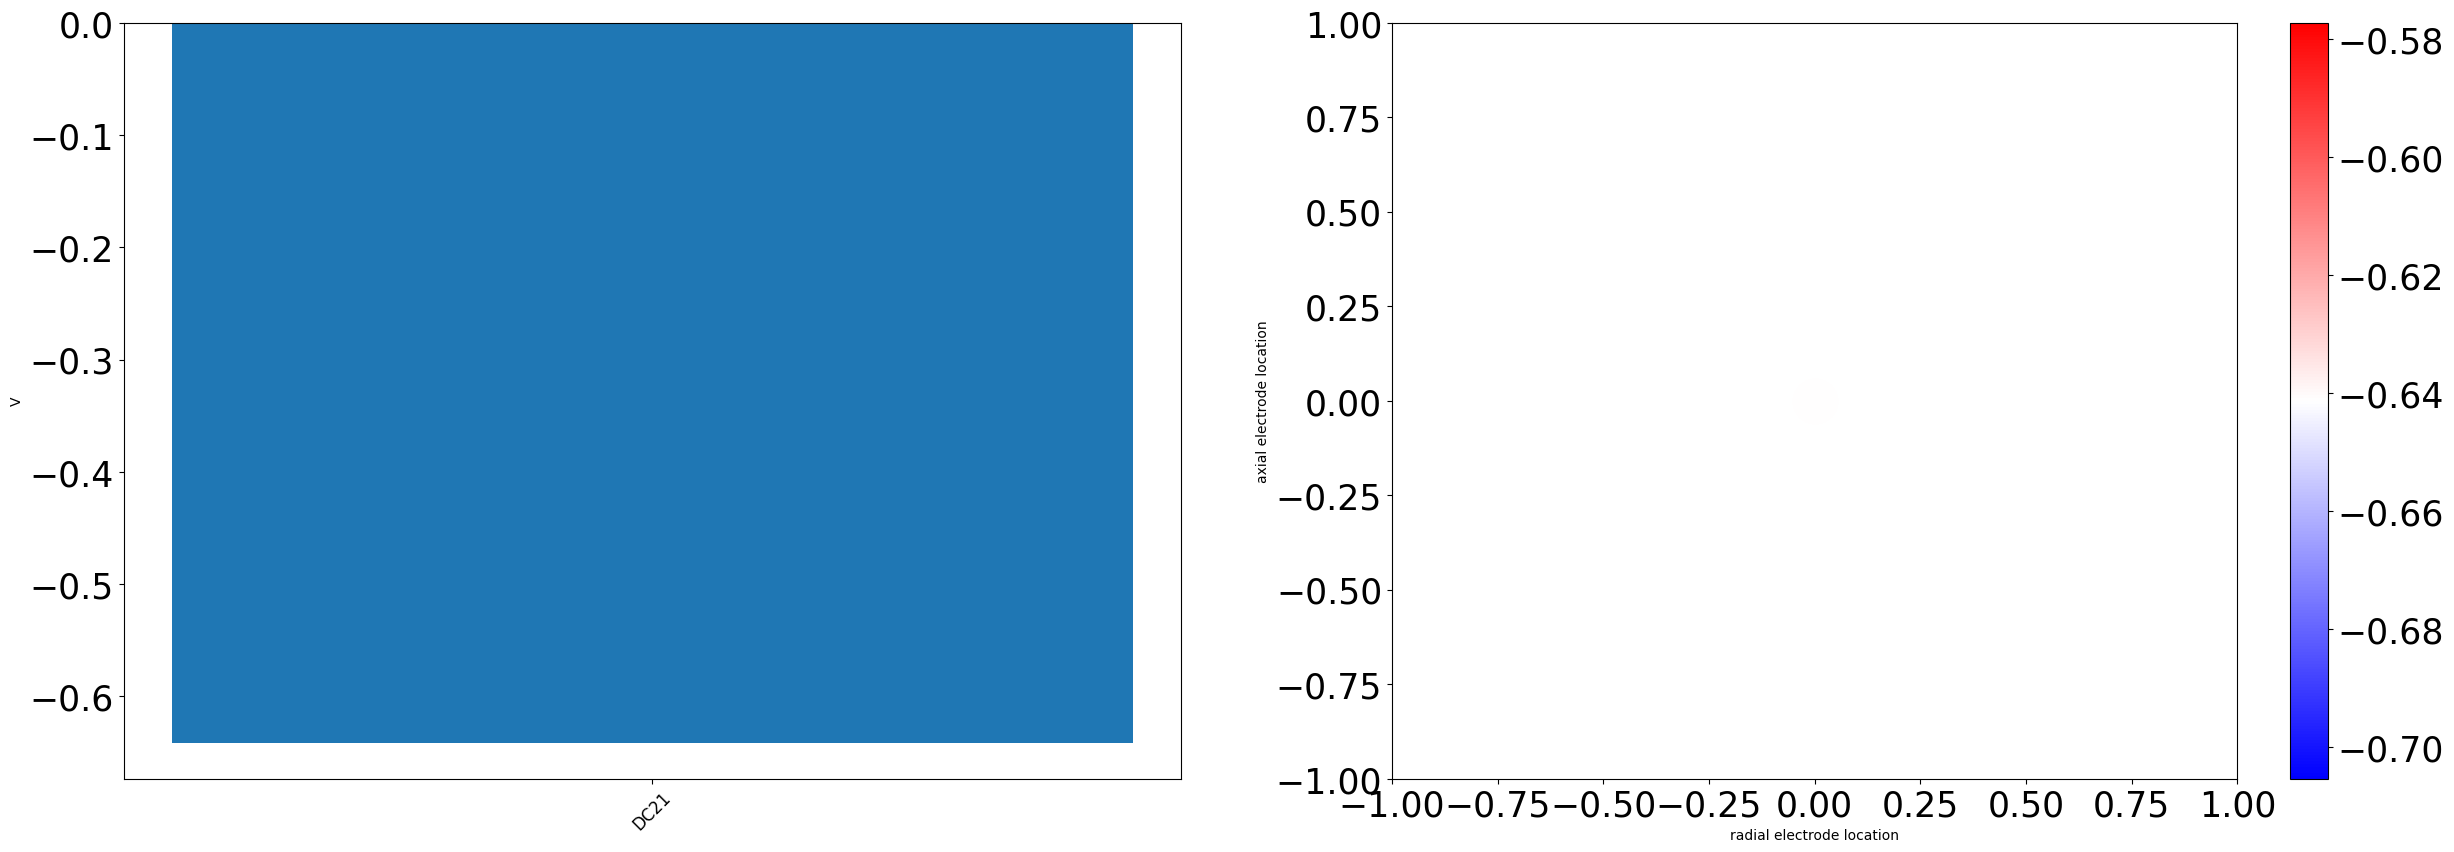

In [ ]:
fig = plt.figure()
fig.canvas.draw()
fig.tight_layout(pad=1)

plot_muls(s,xl,zl,roi,height= 50, ez=0, ex=0, ey=0,u2=10, u5=0, u1=0, u3=0,u4=0)

## Generating Axial Confinment
Here are plots of asking for a pure U2 multiple, which generates confinement in the z-dir

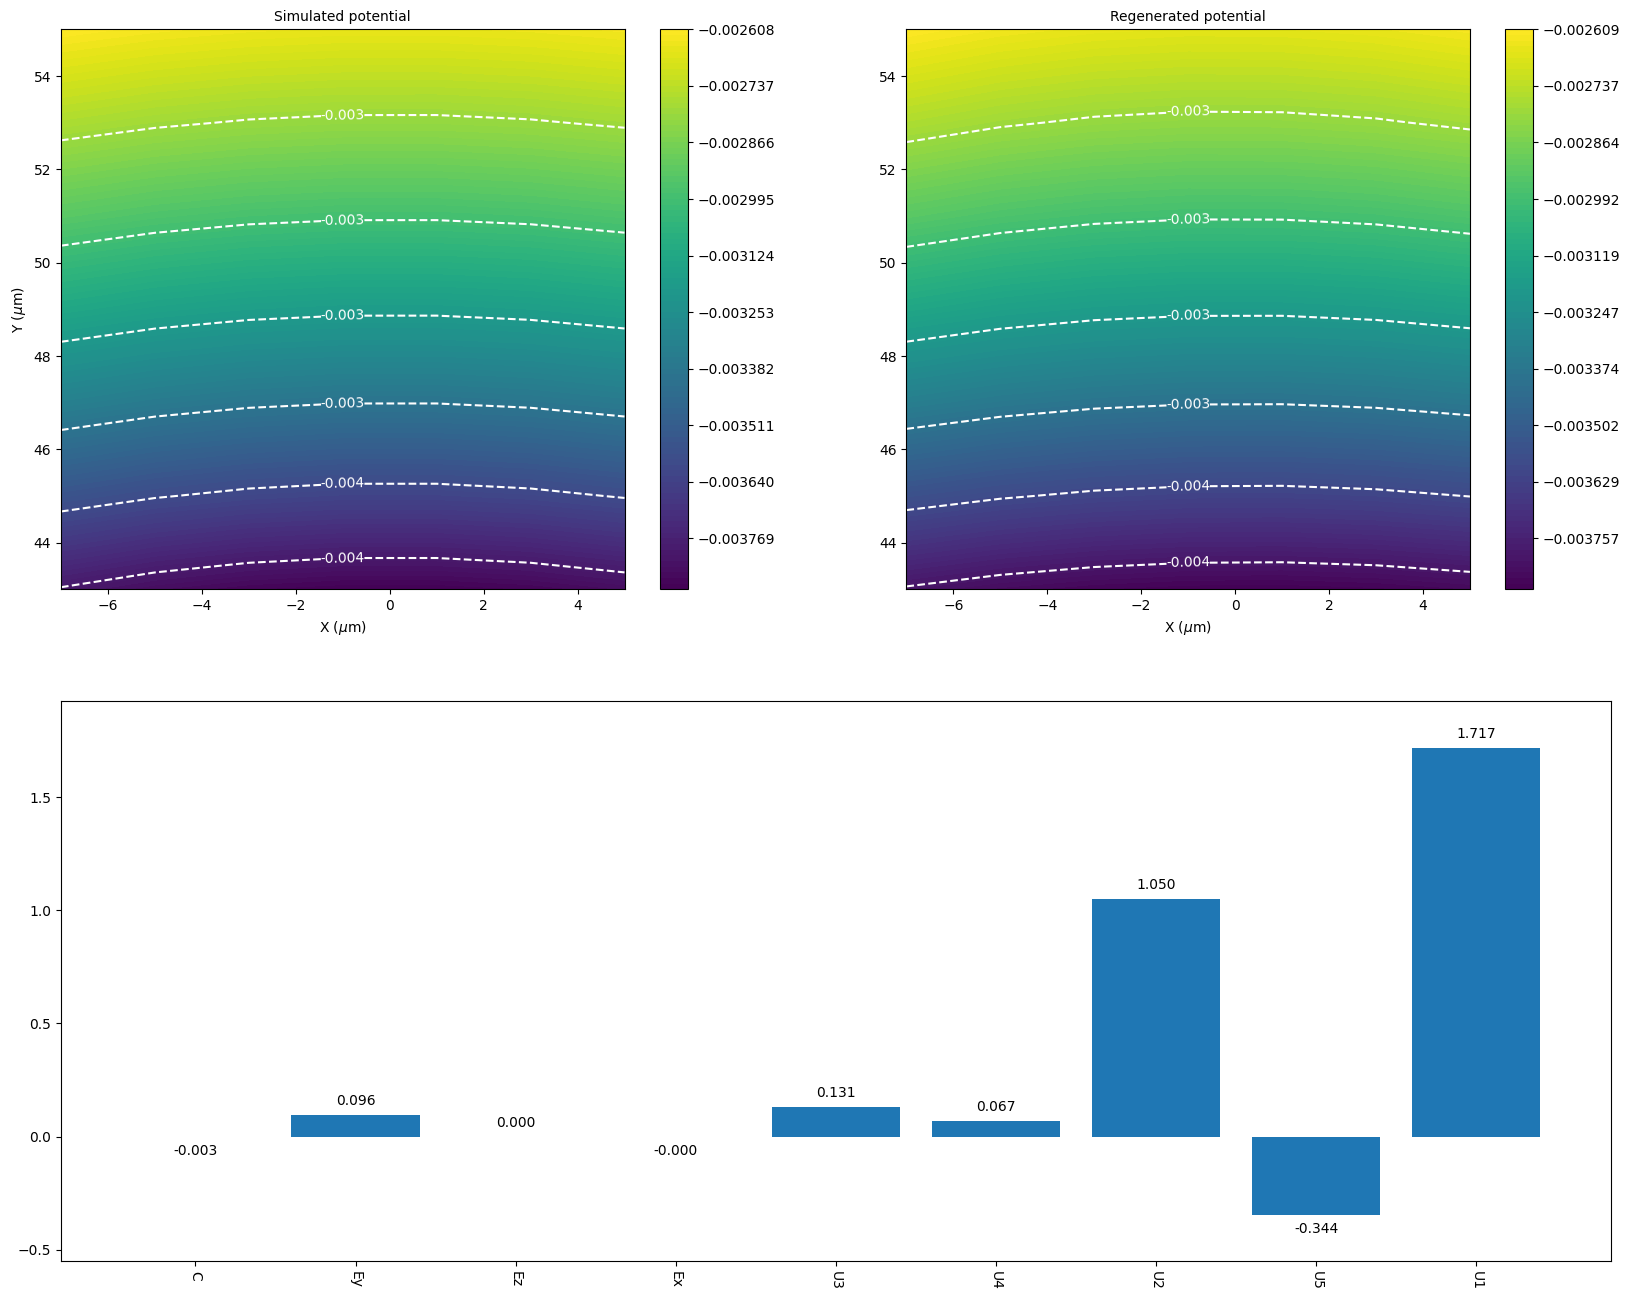

3
(7, 7, 7)


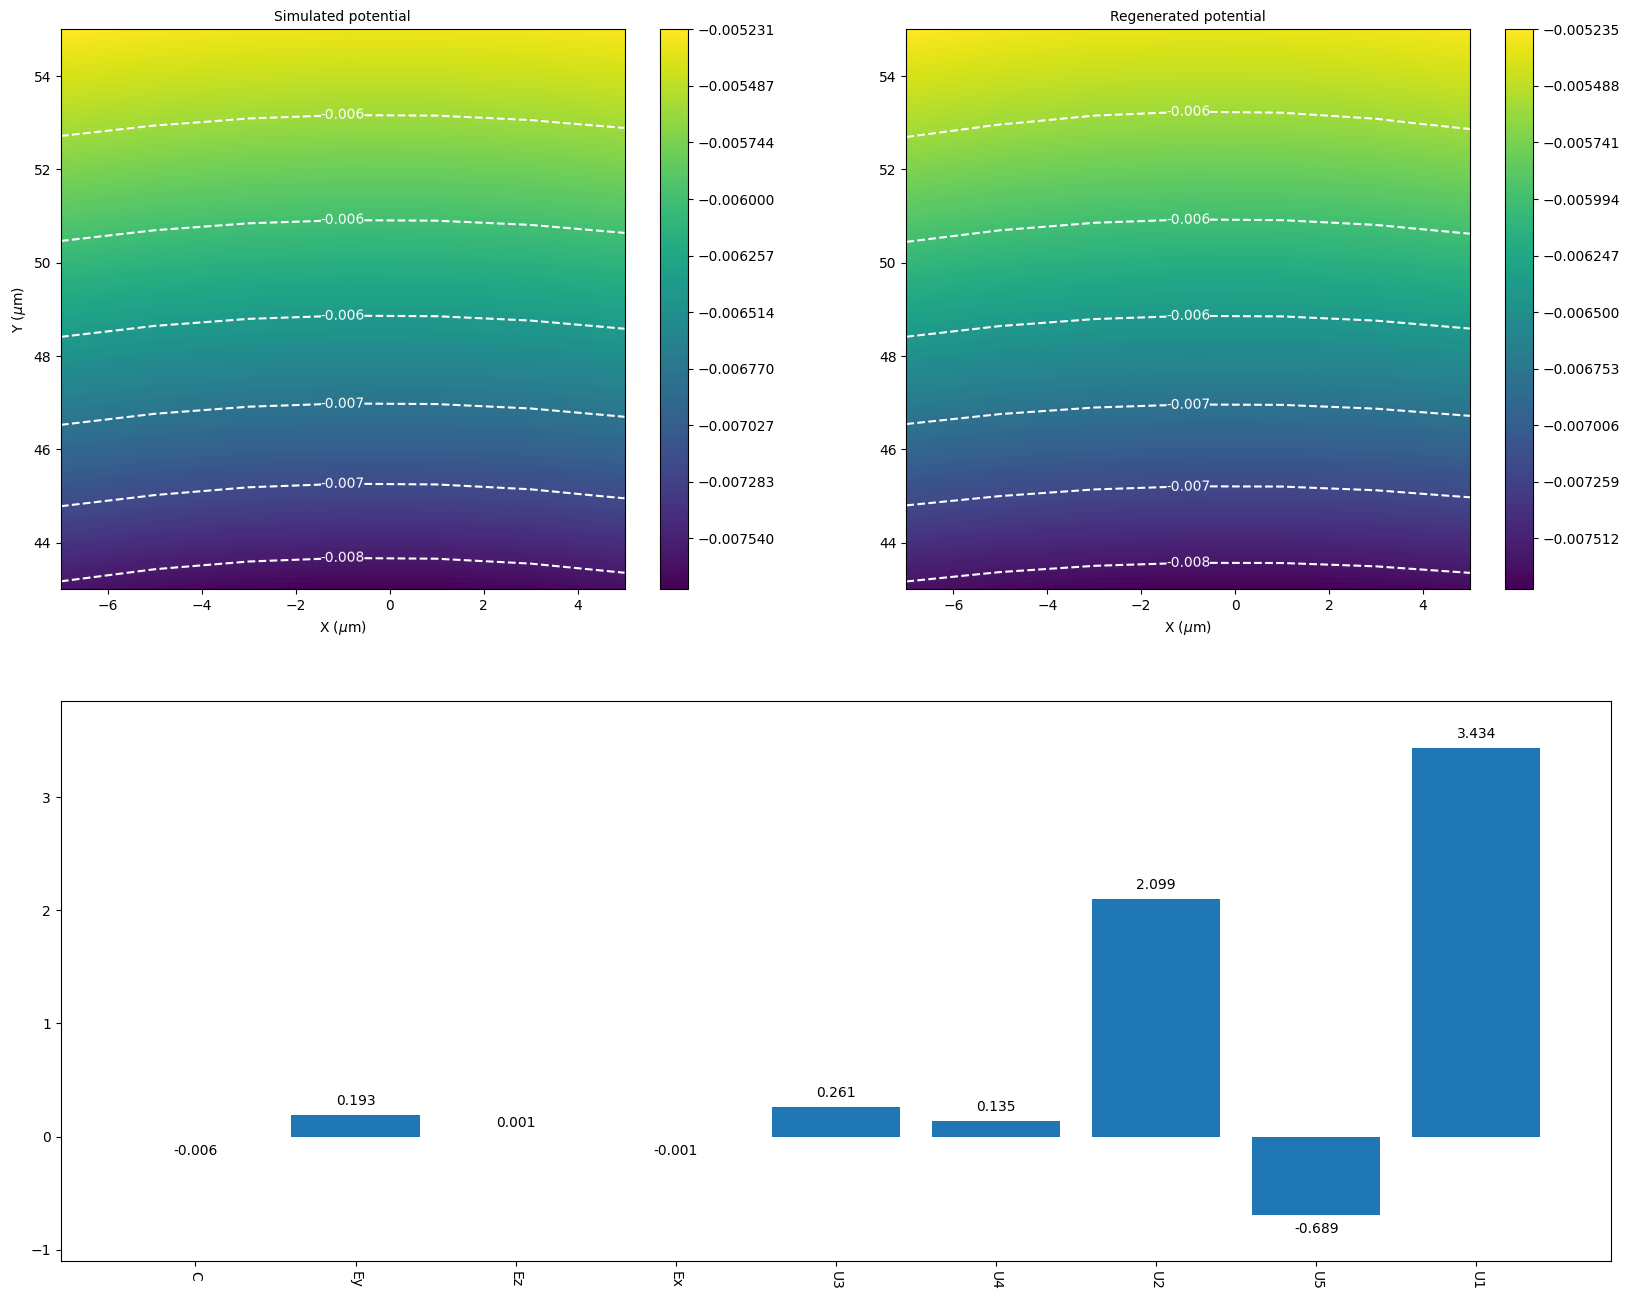

In [ ]:
import matplotlib as mpl
mpl.rc('xtick', labelsize=10) 
mpl.rc('ytick', labelsize=10) 
u4 = 0
# plot_U2(s,xl,zl,roi,height=50.00, ez=0, ex=0, ey=0, u2=10, u5=0, u1=0, u3=0)
def plot_U21(s,xl,zl,roi,height, ey, ez, ex, u3, u2, u5, u1,view='zy'):
    position1 = [xl, height * 1e-3, zl]
    s.update_origin_roi(position1, roi)
    multipole_coeffs = {'Ey': ey, 'Ez': ez, 'Ex': ex, 'U3': u3, 'U2': u2, 'U5': u5, 'U1': u1,'U4':u4}
    voltages = s.setMultipoles(multipole_coeffs)
    potential_roi = s.potentialControl_roi(voltages)
    potential_regen = s.potentialControl_regen(voltages)
    # nearestZ = find_nearest(s.Z, height * 1e-3)
    # indNearestZ_roi = np.abs(s.Z_roi - nearestZ).argmin()
    fsize = 10
    fig1 = plt.figure(figsize=(20, 16))
    if view == 'zy':
        nearestX = find_nearest(s.X, xl)
        indNearestX_roi = np.abs(s.X_roi - nearestX).argmin()
        print(indNearestX_roi)
        print(np.shape(potential_roi))
        potential_xy_roi = potential_roi[indNearestX_roi]
        potential_xy_regen = potential_regen[indNearestX_roi]
        fig.suptitle('Z-Y Plane',fontsize=20)
    else:
        nearestZ = find_nearest(s.Z, zl)
        indNearestZ_roi = np.abs(s.Z_roi - nearestZ).argmin()
        potential_xy_roi = potential_roi[:,:,indNearestZ_roi]
        potential_xy_regen = potential_regen[:,:,indNearestZ_roi]
        potential_xy_regen = np.transpose(potential_xy_regen)
        potential_xy_roi = np.transpose(potential_xy_roi)
        fig.suptitle('X-Y Plane',fontsize=20)
    grid = plt.GridSpec(2, 2)
    ax1 = fig1.add_subplot(grid[0, 0])
    ax2 = fig1.add_subplot(grid[0, 1])
    ax3 = fig1.add_subplot(grid[1, :])
    ax1.set_title('Simulated potential', fontsize=fsize)
    levels1 = np.linspace(np.amin(potential_xy_roi), np.amax(potential_xy_roi), 100)
    plot1 = ax1.contourf(s.Z_roi * 1e3, s.Y_roi * 1e3, potential_xy_roi, levels1, cmap=plt.cm.viridis)
    plot1_line = ax1.contour(s.Z_roi * 1e3, s.Y_roi * 1e3, potential_xy_roi, colors='w')
    #     ax1.clabel(plot1_line, inline = 1, fontsize = fsize)
    ax1.clabel(plot1_line, colors='w', fmt='%2.3f', fontsize=fsize)
    ax1.set_xlabel('X ($\mu$m)', fontsize=fsize)
    ax1.set_ylabel('Y ($\mu$m)', fontsize=fsize)
    plt.colorbar(plot1, ax=ax1)

    ax2.set_title('Regenerated potential', fontsize=fsize)
    levels2 = np.linspace(np.amin(potential_xy_regen), np.amax(potential_xy_regen), 100)
    plot2 = ax2.contourf(s.Z_roi * 1e3, s.Y_roi * 1e3, potential_xy_regen, levels2, cmap=plt.cm.viridis)
    plot2_line = ax2.contour(s.Z_roi * 1e3, s.Y_roi * 1e3, potential_xy_regen, colors='w')
    #     ax2.clabel(plot2, inline = 1, fontsize = fsize)
    ax2.clabel(plot2_line, colors='w', fmt='%2.3f', fontsize=fsize)
    ax2.set_xlabel('X ($\mu$m)', fontsize=fsize)
    plt.colorbar(plot2, ax=ax2)
    coeffs = s.setVoltages(voltages)
    ax3.bar(np.arange(9), np.asarray(coeffs)[0:9])
    max_coeff = np.max(coeffs[0:9])
    min_coeff = np.min(coeffs[0:9])
    margin = (max_coeff - min_coeff) * 0.1
    ymax = max_coeff + margin
    ymin = min_coeff - margin
    ax3.set_ylim(ymin, ymax)
    add_value_labels(ax3)
    ax3.set_xticks(np.arange(9))
    ax3.set_xticklabels(s.multipole_names, rotation=-90, fontsize=fsize)
    plt.show()
plot_U21(s,xl,zl,roi,height=50.00, ez=0, ex=0, ey=0, u2=4, u5=0, u1=0, u3=0,view = 'xy')

plot_U21(s,xl,zl,roi,height=50.00, ez=0, ex=0, ey=0, u2=8, u5=0, u1=0, u3=0,view = 'zy')
# plot_U2(s,xl,zl,roi,height=50.00, ez=0, ex=1, ey=0, u2=0, u5=0, u1=0, u3=0,u4=0,view = 'xy')
# output = interactive_plot.children[-1]
# output.layo

## Plotting Spherical Harmonic  Decomposition
This plots the spherical harmonic decomposition up to 2nd-order of the multipoles of the fields generated by placing 1V on an electrode specified in electrode_list and ground all others.


height_list: [-0.013 -0.011 -0.009 -0.007 -0.005 -0.003 -0.001  0.001  0.003  0.005
  0.007  0.009  0.011  0.013]


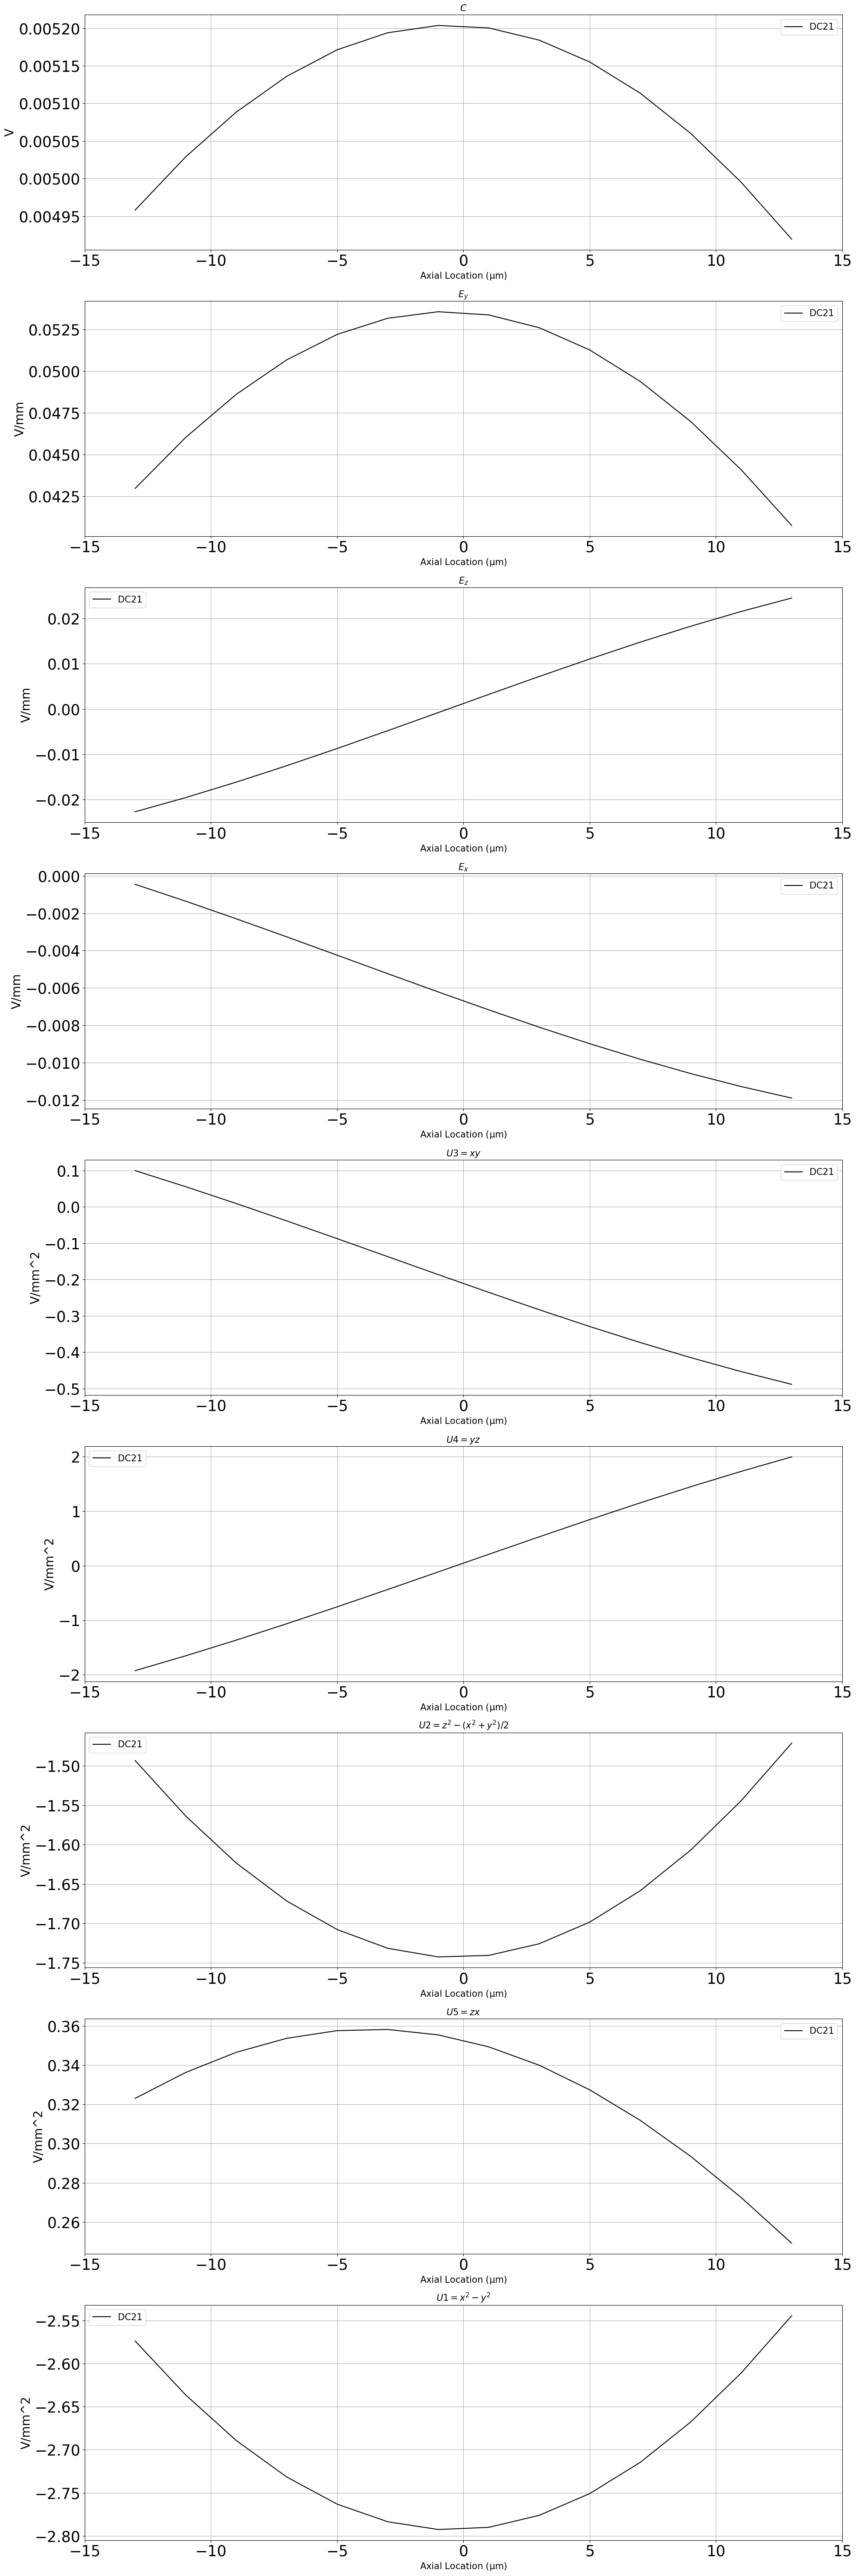

In [ ]:
# 'height list' is the list of the places to do the spherical decomp. of the electrode potential
# if you use too many points it will take a while to generate the plot
print()
numMUltipoles = len(s.multipole_print_names)
ne = len(s.electrode_names)
multipoles_vs_height = np.zeros((len(height_list), numMUltipoles, ne))
print('height_list:',height_list)
for i, height in enumerate(height_list):
    position1 = [xl, yl,height]
    s.update_origin_roi(position1, roi)
    multipoles_vs_height[i] = np.asarray(s.multipole_expansion.loc[s.multipole_names])

size = 20
electrode_list = ['DC3','DC4','DC5','DC6','DC14','DC15','DC16']
electrode_list = ['DC21']

fig, ax = plt.subplots(numMUltipoles, 1, figsize=(20, 60))
for i, mul in enumerate(s.multipole_print_names):
    ax[i].set_prop_cycle(linestyle = ['-','-','-','-','-','--','--','--','--','--'],color= ['black','blue','purple','red','orange','black','blue','purple','red','orange'])
    for ele in electrode_list:
        j = s.electrode_names.index(ele)
        ax[i].plot(height_list*1e3, multipoles_vs_height[:, i, j], label=ele)
        if i == 0:
            ax[i].set_ylabel('V',fontsize=size)
        elif i < 4:
            ax[i].set_ylabel('V/mm',fontsize=size)
        else:
            ax[i].set_ylabel('V/mm^2',fontsize=size)
        ax[i].set_title(mul, fontsize=f)
        ax[i].set_xticks(np.arange(-15,20,5))
        ax[i].set_xlabel(r'Axial Location ($\mathrm{\mu}$m)', fontsize=size)
        ax[i].grid(visible=True)
        ax[i].legend(fontsize=size)
    fig.tight_layout()

In [ ]:
# %% md
# plot coefficients can be achieved for each multipole (controlled individually) when apply max 30 volts
# %%
numMUltipoles = len(used_multipoles)
Coeffs = pd.DataFrame()
for height in height_list:
    position1 = [xl, yl,height*1e-3]
    s.update_origin_roi(position1, roi)

    Coeffs_temp = pd.Series(dtype=float)
    for key in used_multipoles:
        multipole_coeffs = pd.Series(np.zeros(len(used_multipoles)), index=used_multipoles)
        multipole_coeffs[key] = 1
        voltages = s.setMultipoles(multipole_coeffs)
        max_v = np.max(abs(voltages))
        Coeffs_temp[key] = 30 / max_v

    Coeffs[height] = Coeffs_temp

size = 25
plt.rc('xtick', labelsize=size)    # fontsize of the tick labels
plt.rc('ytick', labelsize=size)    # fontsize of the tick labels

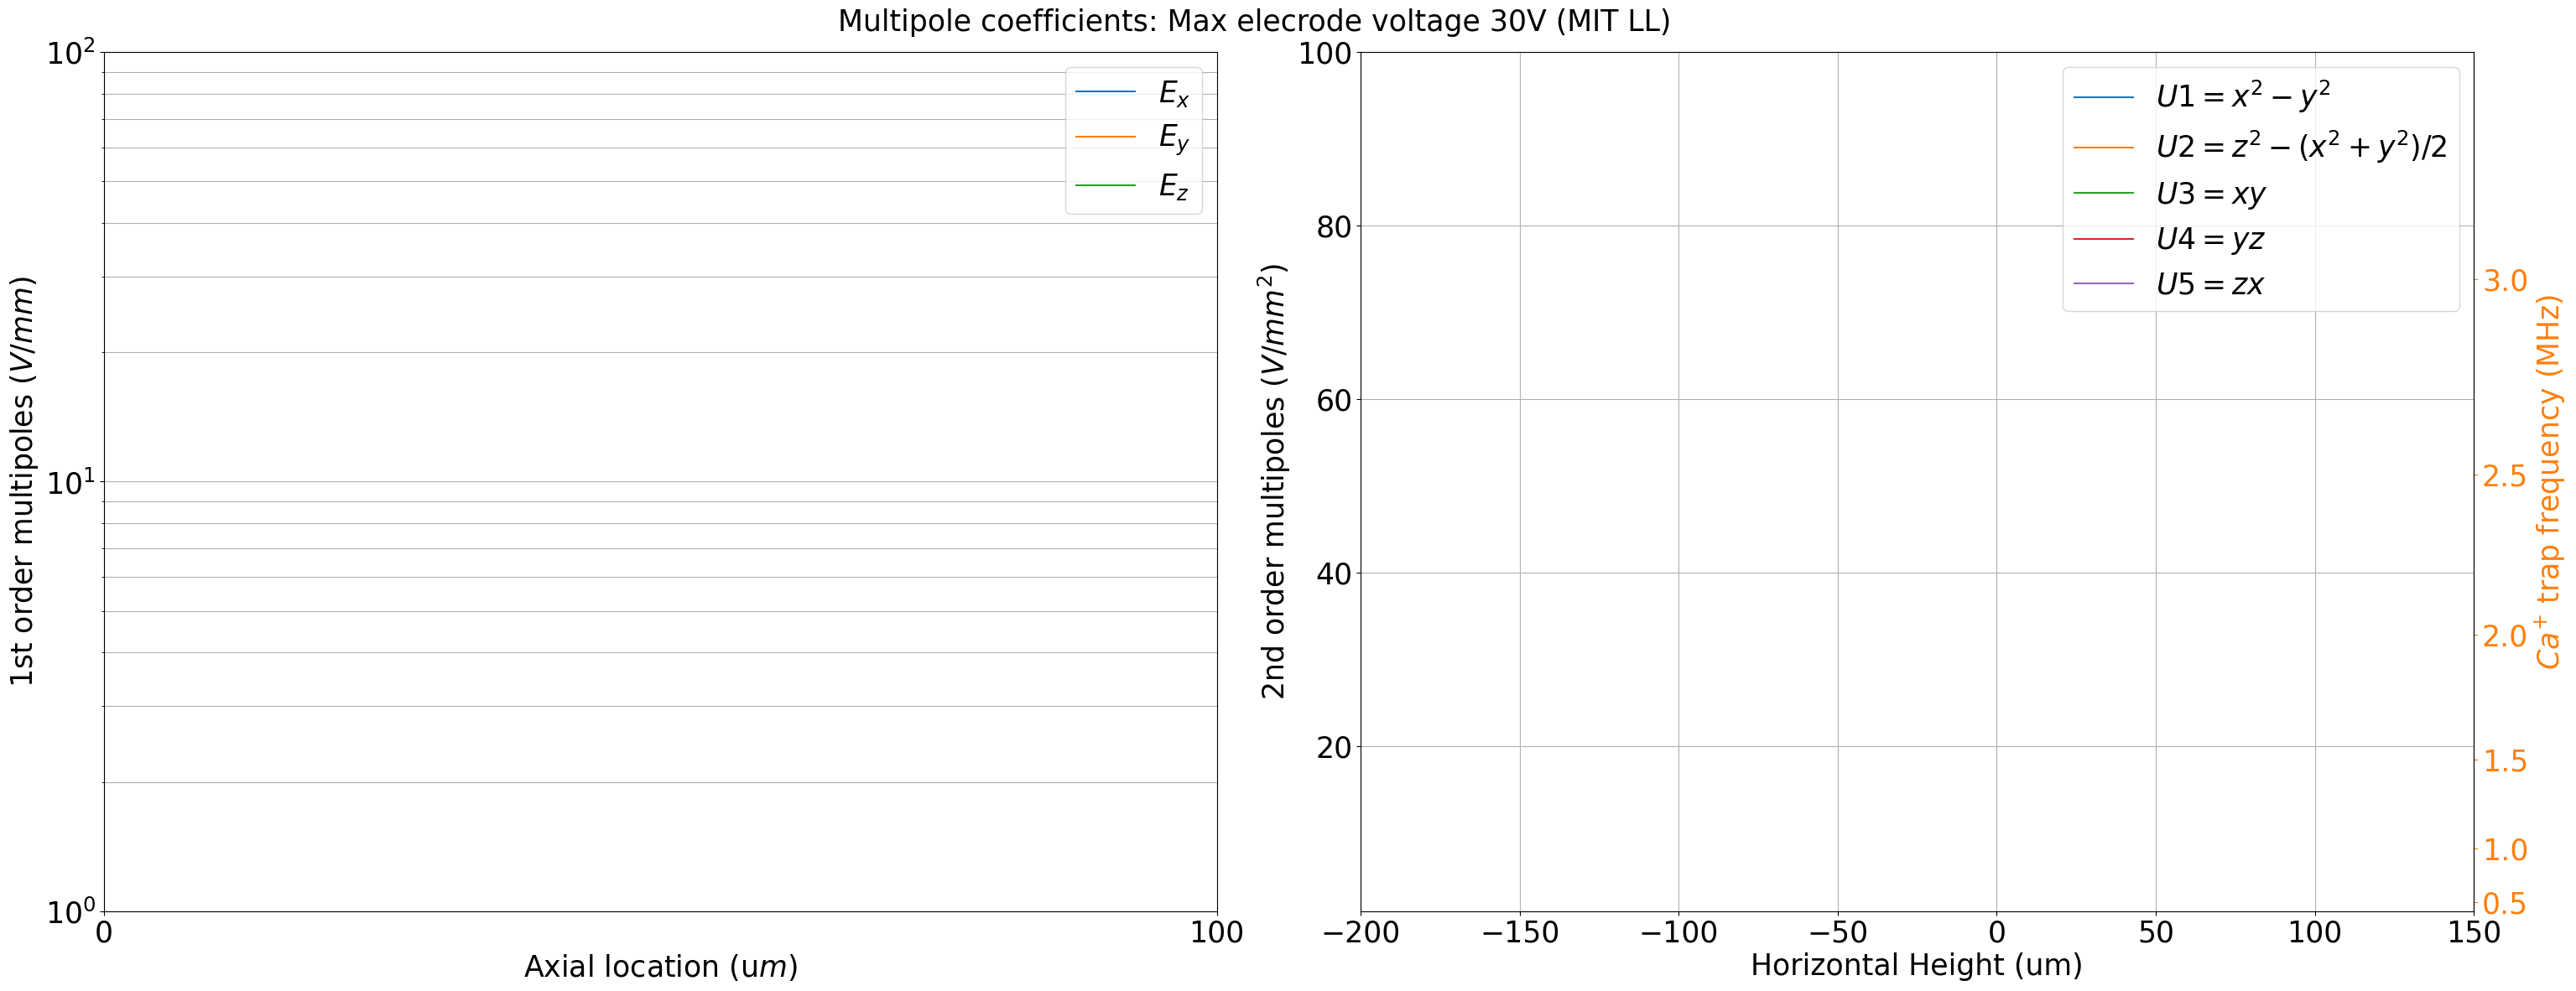

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 12))
 

for mul in used_order1multipoles:
    ax1.plot(height_list, Coeffs.loc[mul], label=s.multipole_print_names[mul])
ax1.set_yscale('log')
ax1.set_ylabel(r'1st order multipoles $(V/mm)$', fontsize=size)
ax1.set_xticks(np.arange(00, 200, 100))
ax1.set_xlabel(r'Axial location ($\mathrm{u}m$)', fontsize=size)
ax2.set_xlabel('Vertical Height ($\mathrm{u}m$)', fontsize=size)
ax1.tick_params(labelsize=size,which='minor')
ax1.legend(fontsize=size)
ax1.set_ylim(1, 100)  # set ylim


ax1.grid(which='both')

for mul in used_order2multipoles:
    ax2.plot(height_list, Coeffs.loc[mul], label=s.multipole_print_names[mul])
ax2.set_ylabel(r'2nd order multipoles $(V/mm^2)$', fontsize=size)
ax2.set_xticks(np.arange(-200, 200, 50))
ax2.set_xlabel('Axial Location (um)', fontsize=size)
ax2.set_xlabel('Horizontal Height (um)', fontsize=size)

ax2.set_ylim(1, 1e2)  # set ylim
# ax2.set_yscale('log')
# ax2.set_tick_params(axis='y', which='minor')
ax2.tick_params(labelsize=size)
ax2.legend(fontsize=size)
ax2.grid(which='both')
fig.suptitle('Multipole coefficients: Max elecrode voltage 30V (MIT LL)', fontsize=size)
fig.tight_layout(pad=1)

secax = ax2.secondary_yaxis('right', functions=(U2_to_mhz, mhz_to_U2))
secax.tick_params(labelsize=size, colors='#ff7f0e')
secax.set_ylabel('$Ca^{+}$ trap frequency (MHz)', fontsize=size, color='#ff7f0e')

# plt.savefig('Multipole_coeffs_20v_rfbias.jpg', format = 'jpg', dpi = 300) 

# plot_1d(s,xl,zl,roi,height=75, ez=0, ex=0, ey=0, u2=10,u5=0, u1=0, u3=0)
# %%
outarray = []

# plot_U2(s,xl,zl,roi,height=50.00, ez=0, ex=0, ey=0, u2=10, u5=0, u1=0, u3=0)
# output = interactive_plot.children[-1]
# output.layout.height = '1000px'

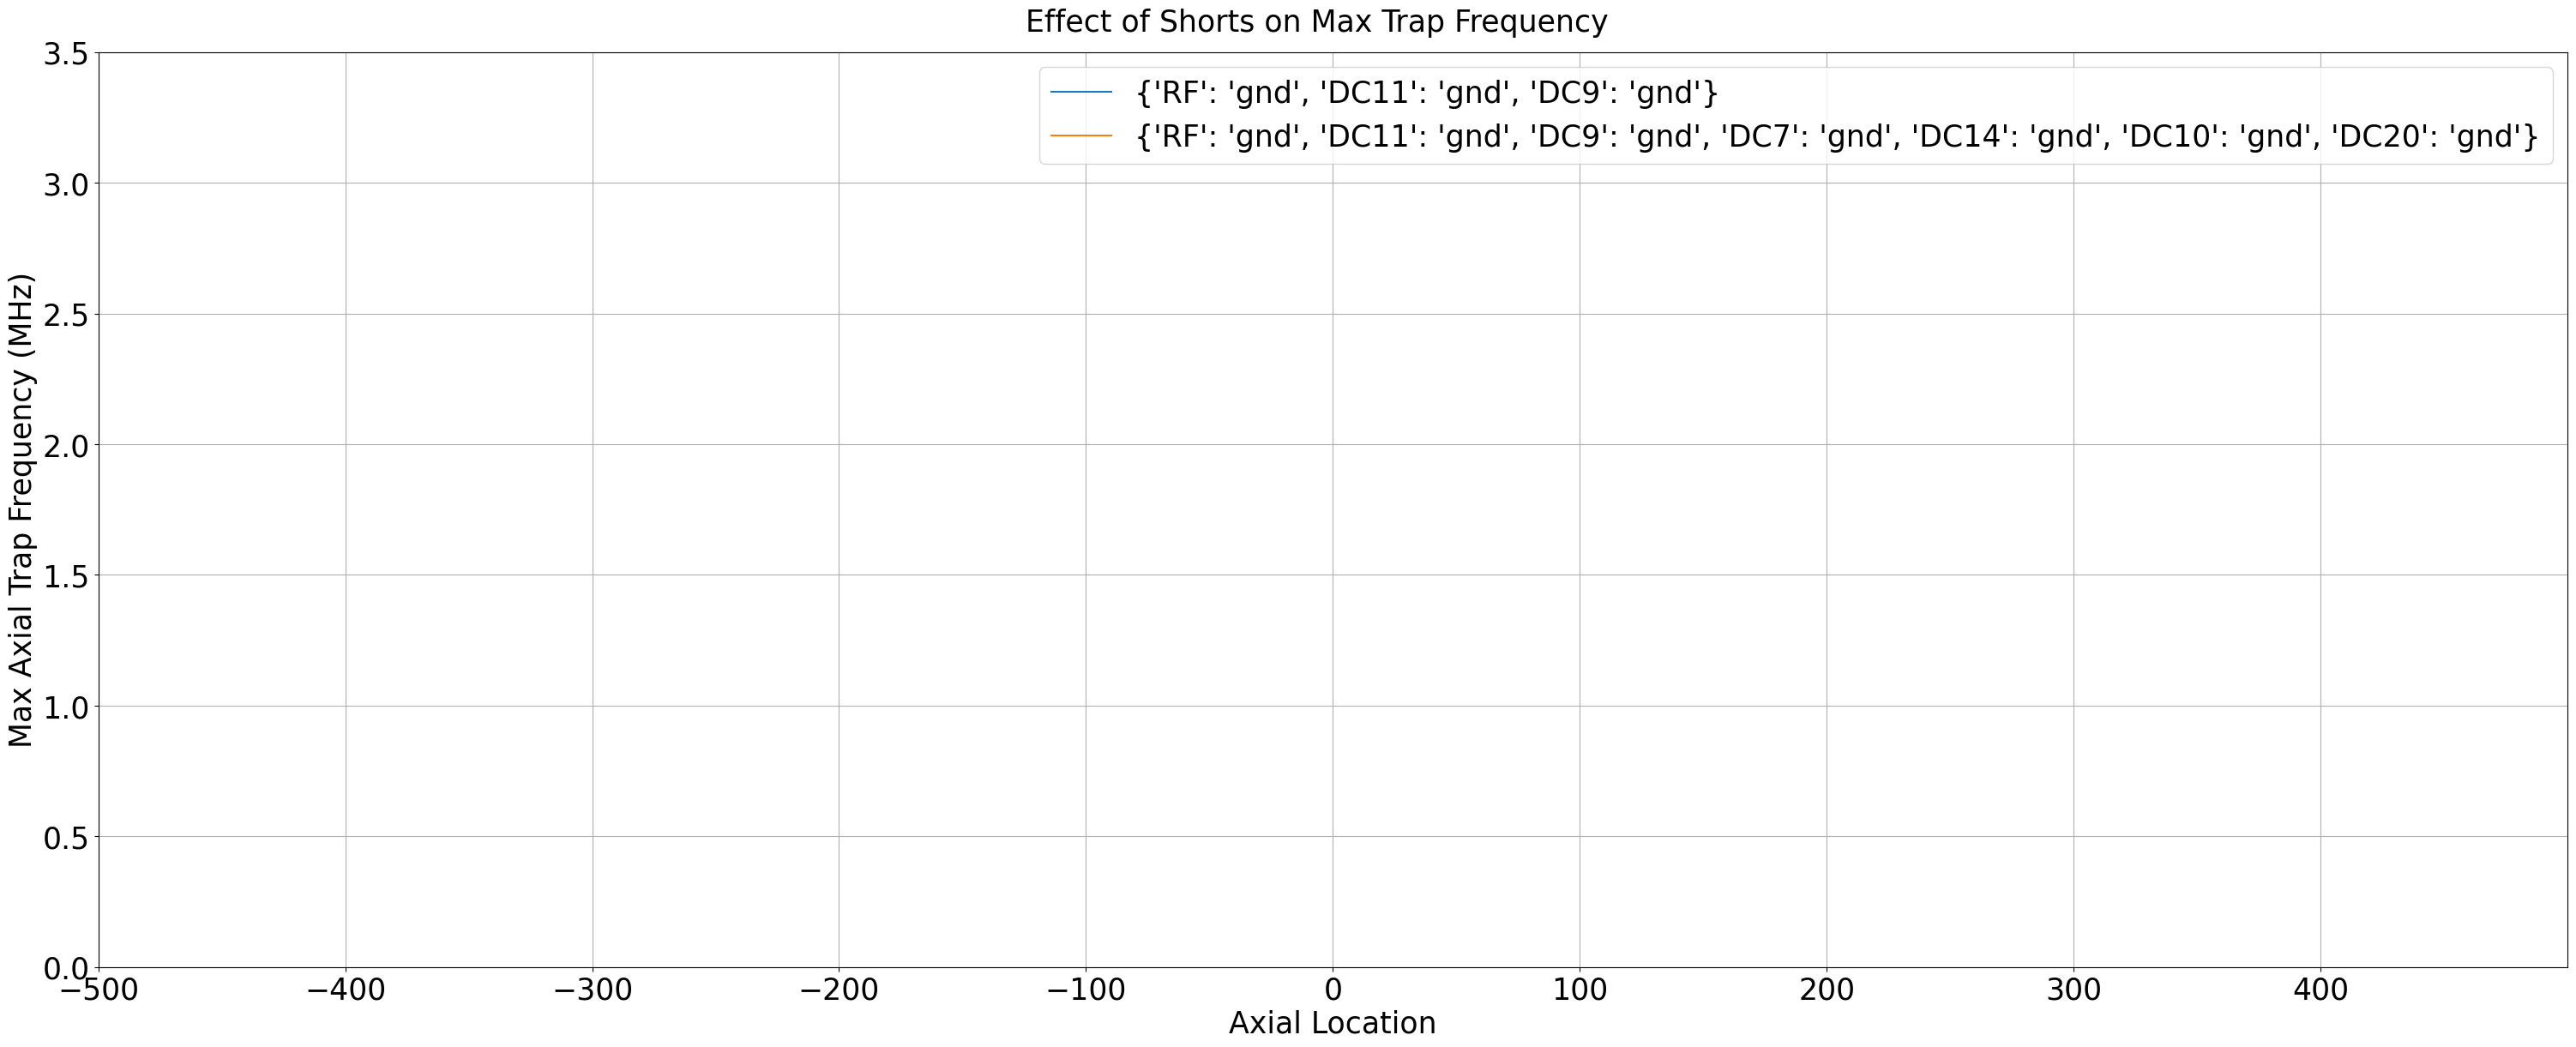

In [ ]:
def build_electrode_config(all_electrodes, exclusions):
    #build the controlled electrodes list, given the constraints of the 'exclusion' list
    #controlled electrodes- this will define which electrodes will be used to control your trap
    controlled_electrodes = []
    for electrode in strs:
        if electrode in exclusions and exclusions[electrode] != "gnd":
            trap['electrodes'][exclusions[electrode]]["potential"] = trap['electrodes'][exclusions[electrode]]["potential"] + \
                                                            trap['electrodes'][electrode]["potential"]
        elif electrode not in exclusions:
            controlled_electrodes.append(electrode)
    return controlled_electrodes

def plot_control_config(exclusion_list,ax2):
    controlled_electrodes = build_electrode_config(strs,exclusion_list)
    # create MultipoleControl object
    s = MultipoleControl(trap, position, roi, controlled_electrodes, used_multipoles, order)

    Coeffs = pd.DataFrame()
    for height in height_list:
        position1 = [xl, yl,height]
        s.update_origin_roi(position1, roi)
        Coeffs_temp = pd.Series(dtype=float)
        for key in used_multipoles:
            multipole_coeffs = pd.Series(np.zeros(len(used_multipoles)), index=used_multipoles)
            multipole_coeffs[key] = 1
            voltages = s.setMultipoles(multipole_coeffs)
            max_v = np.max(abs(voltages))
            Coeffs_temp[key] = 30 / max_v
        Coeffs[height] = Coeffs_temp

    ax2.plot(height_list*1e3, U2_to_mhz(Coeffs.loc['U2']), label=exclusion_list)
    ax2.set_ylabel(r'Max Axial Trap Frequency (MHz)', fontsize=size)
    ax2.set_xticks(np.arange(-500, 500, 100))
    ax2.set_xlabel(r'Axial Location', fontsize=size)

    ax2.set_ylim(0,3.5)  # set ylim
    ax2.set_xlim(-500,500)
    ax2.tick_params(labelsize=size)
    ax2.legend(fontsize=size)
    ax2.grid(which='both')
excl0 = {
    "RF":"gnd",
    "DC11":"gnd",
    "DC9":"gnd",
    # "DC10":"gnd",
    # "DC20":"gnd",
}
excl1 = {
    "RF":"gnd",
    "DC11":"gnd",
    "DC9":"gnd",
    "DC7":"gnd",
    "DC14":"gnd",
    'DC10':"gnd",
    "DC20":"gnd"
}
#which multipoles you want to include in multipole calculations
used_order1multipoles = ['Ex', 'Ey', 'Ez']
used_order2multipoles = ['U1', 'U2', 'U3','U4','U5']
used_multipoles = used_order1multipoles + used_order2multipoles
size = 25
numMUltipoles = len(used_multipoles)
fig, ax2 = plt.subplots(1, 1, figsize=(30, 12))
ax2.grid()
fig.suptitle('Effect of Shorts on Max Trap Frequency', fontsize=size)
fig.tight_layout(pad=1)
plt.rc('xtick', labelsize=size)    # fontsize of the tick labels
plt.rc('ytick', labelsize=size)    # fontsize of the tick labels
plot_control_config(excl0,ax2)
plot_control_config(excl1,ax2)
plt.show()

Text(0, 0.5, '$Ca^{+}$ trap frequency (MHz)')

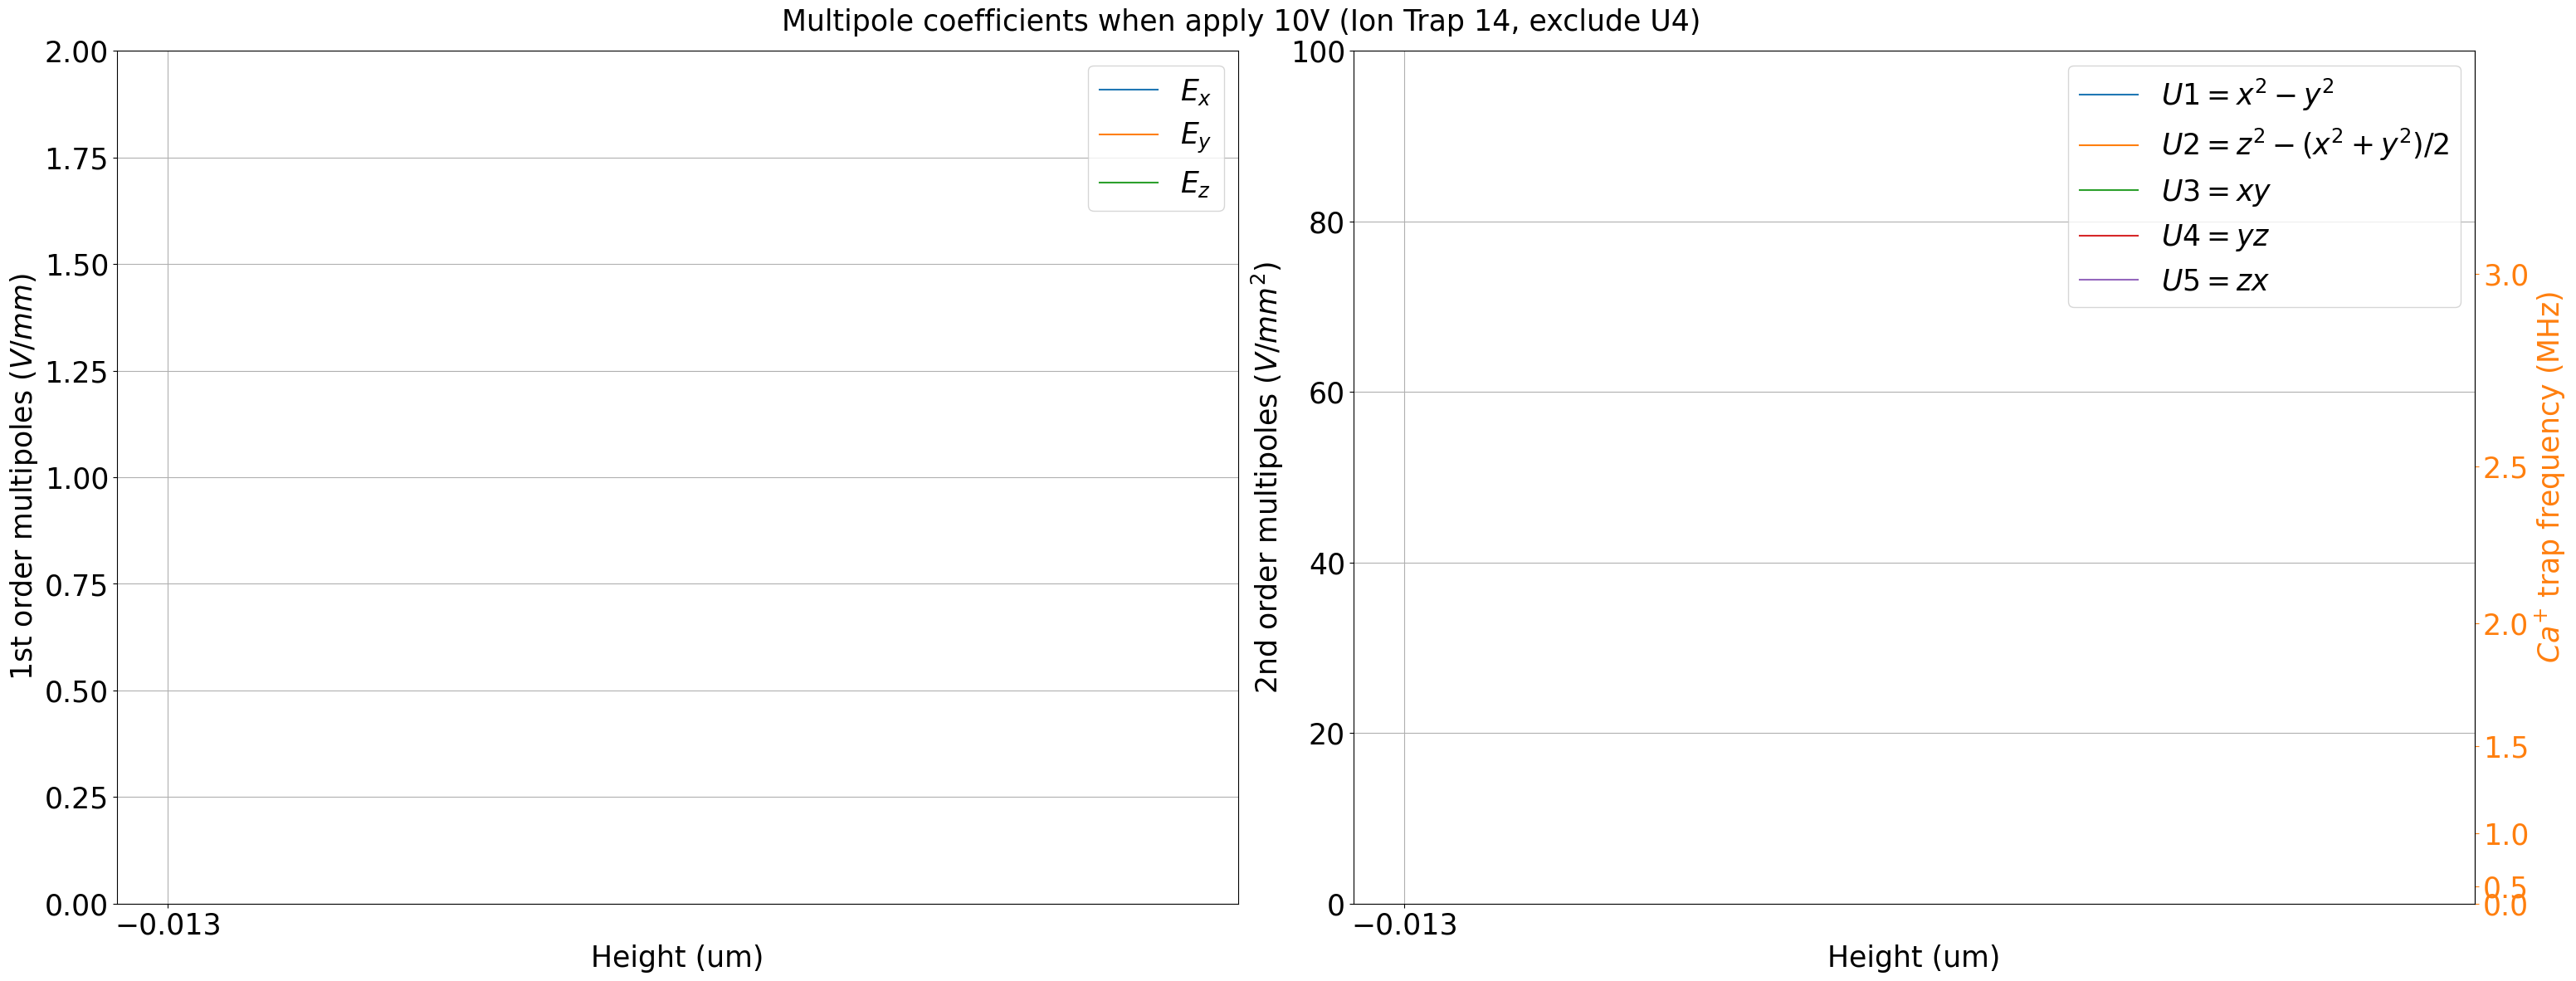

In [ ]:
# %% md
# plot coefficients can be achieved for each multipole (controlled individually) when apply max 40 volts
# %%
excl = {
    # "DC6": "gnd",
    #     "DC4": "gnd",
        # "DC5": "gnd",
    #     "DC8": "gnd",
    #     "DC14": "DC13",
        # "DC11": "gnd",
        # "DC12": "gnd",
#     "DC1": "gnd",
#     "DC19": "gnd",
    "RF":"gnd"
}
numMUltipoles = len(used_multipoles)

size = 25
plt.rc('xtick', labelsize=size)    # fontsize of the tick labels
plt.rc('ytick', labelsize=size)    # fontsize of the tick labels
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 12))


for mul in used_order1multipoles:
    ax1.plot(height_list, Coeffs.loc[mul], label=s.multipole_print_names[mul])
ax1.set_ylabel(r'1st order multipoles $(V/mm)$', fontsize=size)
ax1.set_xticks(np.arange(height_list[0], height_list[-1] + 1, 5))
ax1.set_xlabel('Height (um)', fontsize=size)
ax1.tick_params(labelsize=size)
ax1.legend(fontsize=size)

ax1.set_ylim(0, 2)  # set ylim

ax1.grid(True)

for mul in used_order2multipoles:
    ax2.plot(height_list, Coeffs.loc[mul], label=s.multipole_print_names[mul])
ax2.set_ylabel(r'2nd order multipoles $(V/mm^2)$', fontsize=size)
ax2.set_xticks(np.arange(height_list[0], height_list[-1] + 1, 5))
ax2.set_xlabel('Height (um)', fontsize=size)

ax2.set_ylim(0, 100)  # set ylim


ax2.tick_params(labelsize=size)
ax2.legend(fontsize=size)
ax2.grid(True)
fig.suptitle('Multipole coefficients when apply 10V (Ion Trap 14, exclude U4)', fontsize=size)
fig.tight_layout(pad=1)

secax = ax2.secondary_yaxis('right', functions=(U2_to_mhz, mhz_to_U2))
secax.tick_params(labelsize=size, colors='#ff7f0e')
secax.set_ylabel('$Ca^{+}$ trap frequency (MHz)', fontsize=size, color='#ff7f0e')